## Data Sources

*   Downloaded Dataset (Covid data): https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD
*   1- Web Collection Source (stock market data): https://finance.yahoo.com/quote/%5EGSPC/history/
*   2- Web Collection Source (article data): https://open-platform.theguardian.com/access/

In [1]:
def period_adv(newcovvl,doww):  #function for averaging values between stock market trading days
    mask = newcovvl["submission_date"].isin(doww["Date"].values) #find the covid data dates on stock trading days
    s = 0        #initializing for loop
    divisor = 1
    
    for each in range(1,len(newcovvl)):           
        if mask[each] == False:     #finds if a covid entry date is not in the dow data
            value += newcovvl.iloc[each,11]     #add cases to value to be reassigned later
            divisor += 1    #create a divisor based on number of values added to get an average
            s = 1    #establish this row is not a trading day
        else:
            if s == 1:  #previous date not a trading day
                newcovvl.iloc[ind,11] = (value/divisor)   #store average value of cases at the last trading date
                s = 0      #establish this row is a trading day
                divisor = 1 #reset divisor
            else:
                value = newcovvl.iloc[each,11]    #establish value to be used in adverage if the next day is a non trading date
                ind = each                   #store the indicy of this row to later change data
                s = 0         #establish this row is a trading day
    return newcovvl

# Data Visualizations

## Insights

# Insight 1: Correlation between Dow Jones price and daily Covid-19 cases

In [2]:
def insight1():
    import pandas as pd
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')  # was giving a chained assignment warning but it isn't an issue in this context
    
    with open("COV_dat.csv") as fc:                #importing csv data to a pandas df
        newcovv = pd.read_csv(fc,delimiter = ",")
    with open("DOW_price.csv") as fd:
        doww = pd.read_csv(fd,delimiter = ",")
        
    
    #sum probable and confirmed new cases to get total new cases
    newcovv["totnew_case"] = newcovv["new_case"]+newcovv["pnew_case"]
    
    newcovv["totnew_case"] = newcovv["totnew_case"].astype(int)

    newcovvl = newcovv.iloc[1:,:]       #first covid date not in dow data; clipping this allows the function to run properly
    peradv = period_adv(newcovvl,doww)
    newcovv.iloc[1:,:] = peradv
    
    newcov2 = newcovv[newcovv["submission_date"].isin(doww["Date"].values)]  #remove rows with dates not in dow dataframe
    newcov2.reset_index(drop =True,inplace = True)
    
    doww["Daily Change"] = doww["Open"].pct_change() #converting dow opens into daily % changes
    doww = doww.iloc[1:,:]   # clipping first value as pct chagne retruns a Nan for the first value
    newcov2 = newcov2.iloc[:-1,:]  #clipping last value to match length of doww and compare covid cases from one day
    #with the change of the open the next trading day
    doww.reset_index(drop =True,inplace = True) #reset the indexes so doww and covv indexes aligned when concatenating

    reg = newcov2["totnew_case"].corr(doww["Daily Change"],method="spearman")
    print(f"Spearman correlation test results\nCorrelation Coefficient: {reg}")
    
    newcov2["Total New Cases"] = newcov2["totnew_case"]
    plot_df = pd.concat([newcov2, doww], axis =1)         #getting data for scatter plot in one df
    plot_df = plot_df[["Total New Cases", "Daily Change"]]
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 1
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_df.plot.scatter(x='Total New Cases', y='Daily Change')

############ Function Call ############
    insight1()

# Insight 2: The death rate of Covid-19 over time

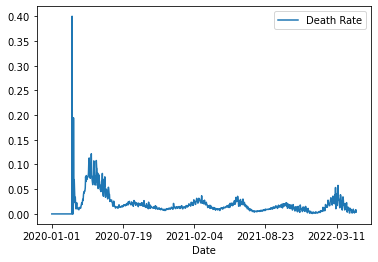

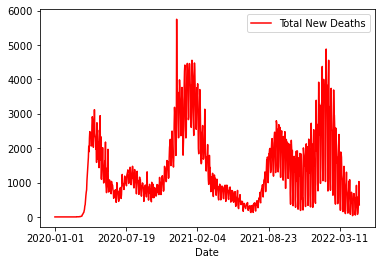

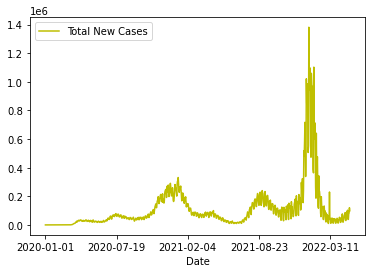

In [3]:
def insight2():
    import pandas as pd
    with open("COV_dat.csv") as f:
        cdata = pd.read_csv(f, delimiter = ",")
        
        cdata["Total New Cases"] = cdata["new_case"]+cdata["pnew_case"]     #sum probable with confirmed deaths/cases
        cdata["Total New Deaths"] = cdata["new_death"]+cdata["pnew_death"]
        
        cov = cdata[["submission_date", "Total New Cases", "Total New Deaths"]] #compile needed data
        cov = cov.sort_values(by = "submission_date", ascending = True)  #sort by date
        cov["Death Rate"] = cov["Total New Deaths"]/cov["Total New Cases"]  #compute death rate; new deaths/new cases
        cov["Death Rate"]= cov["Death Rate"].fillna(0)
        cov["Date"] = cov["submission_date"]
        
        
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 2
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    cov.plot.line(x="Date", y="Death Rate")
    cov.plot.line(x="Date", y="Total New Deaths",color="r")
    cov.plot.line(x="Date", y="Total New Cases",color="y")


############ Function Call ############
insight2()

# Insight 3: What time shift gives the greatest correlation between covid cases and the stock market?

In [4]:
def insight3():
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    with open("DOW_price.csv") as fdd:              
        prices = pd.read_csv(fdd, delimiter = ",")
    with open("COV_dat.csv") as fcd:
        vid = pd.read_csv(fcd,delimiter = ",")
        
    vid["totnew_case"] = vid["new_case"]+vid["pnew_case"]
    
    vid["totnew_case"] = vid["totnew_case"].astype(int) 
    vidl = vid.iloc[1:,:]         #first covid date not in dow data; clipping this allows this loop to run properly

    vidl = period_adv(vidl,prices)
    vid.iloc[1:,:]=vidl
    newv = vid[vid["submission_date"].isin(prices["Date"].values)]#remove rows with dates not in dow dataframe 
    newv.reset_index(drop =True,inplace = True)
    
    prices["Open"] = prices["Open"].astype(int)
    prices["Daily Change"] = prices["Open"].pct_change()
    prices = prices.iloc[1:,:]  # clipping first row as pct chagne retruns a Nan for the first value
    prices.reset_index(drop =True,inplace = True)  #makes row indexes start at 0 instead of 1
    newv = newv.iloc[:-1,:]   #removing the last row to match the length of the dow data
    
    marketdates = list(prices["Date"]) #storing dates for useage in loop
    out = [] #initializing list to store values from loop
    for i in range(22): #chose to look at up to approx. a month later (uses trading days only)
        cor = newv["totnew_case"].corr(prices["Daily Change"],method="spearman") #find correlation between cases and price change
        out += [(i,cor)]   #adds day offset and correlation touple to out list
        
        marketdates = marketdates[1:]  # shift the dates so market data corresponds with covid data from an earlier date
        prices = prices.iloc[:-1,:]
        prices["Date"] = marketdates
        
    t = max(out,key=lambda item:item[1]) #finds the offset with the highest correlation and returns that touple
    df = pd.DataFrame(out, columns=['days_after', 'correlation']) #make out list into a pd dataframe
    df = df.sort_values(by = "correlation", ascending = False)
    display(df)
    print("Time shift with the greatest correlation (days,correlation coefficient)")
    print(t)

############ Function Call ############
    insight3()

# Insight 4: Correlation between covid-19 cases and economic sectors

In [5]:
def insight4():
    import pandas as pd
    import seaborn as sns
    with open("Sector_Prices2.csv") as fsec:
        sec = pd.read_csv(fsec,delimiter = ",")
    with open("COV_dat.csv") as fcd:
        vid = pd.read_csv(fcd,delimiter = ",")
        
    vid["totnew_case"] = vid["new_case"]+vid["pnew_case"]
    

    vid["totnew_case"] = vid["totnew_case"].astype(int) 
    vidl = vid.iloc[1:,:]         #first covid date not in dow data; clipping this allows this loop to run properly

    vidl = period_adv(vidl,sec)
    vid.iloc[1:,:]=vidl
    newv = vid[vid["submission_date"].isin(sec["Date"].values)]  #remove rows with dates not in dow dataframe
    newv.reset_index(drop =True,inplace = True)
    
    #get the daily change in the open for each sector
    for z in sec.columns:
        if z not in ["New Cases","Date","Open"]: #exclude columns where pct chagne not applicable
            sec[f"{z}"] = sec[f"{z}"].pct_change()
    sec["Open"] = sec["Open"].pct_change()
    
    newv = newv.iloc[:-1,:] #realign values as pct change returns nan for the first value
    sec = sec.iloc[1:,:]
    sec.reset_index(inplace = True)
    
    sec["New Cases"] = newv["totnew_case"]
    sec = sec.fillna(0)
    
    print(sec.corr(method = "spearman").iloc[1:,11])
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 4
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax = sns.heatmap(sec.corr(method = "spearman").transpose().iloc[1:-1,[11]], vmin=-.05,vmax=.1)
    ax.xaxis.set_ticks_position('top')
    

############ Function Call ############
    insight4()

# Insight 5: Correlation between Dow Jones and Covid-19 related articles

In [6]:
def insight5():
    import pandas as pd
    from datetime import datetime
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib import dates
    import copy
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    with open("DOW_price.csv") as fc:
        prices = pd.read_csv(fc, delimiter = ",")
        #print(prices)
    with open("api_dic_session3.csv") as f:
        news = pd.read_csv(f, delimiter = ",", names = ["Date","art_num"])
    new = copy.deepcopy(news) 
    mask = news["Date"].isin(prices["Date"].values) #find the covid dates that are in the dow dates
    s = 0        #initializing for loop
    divisor = 1
    value = 1
    ind = -1
    #comments for loop under insight 1
    for each in range(1,len(news)):          
        if mask[each] == False:
            value += news.iloc[each,1]
            divisor += 1
            s = 1
        else:
            if s == 1:
                if ind != -1:
                    news.iloc[ind,1] = (value/divisor)
                    s = 0
                else:
                    s = 0
                divisor = 1
            else:
                value = news.iloc[each,1]
                ind = each
                s = 0
                
    mult = prices.merge(news, on = "Date", how = "left")
    mult = mult.fillna(0)
    corr = mult["Open"].corr(mult["art_num"],method="spearman")
    print("Correlation coefficient:")
    print(corr)
    
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ### VISUALIZATION for INSIGHT 5
    ### ~~~~~~~~~~~~~~~~~~~~~~~~~~~

    prices["Open"] = prices["Open"].astype(int)
    prices["Daily Change"] = prices["Open"].pct_change()
    prices = prices.iloc[1:,:]  # clipping first row as pct chagne retruns a Nan for the first value
    prices = prices.reset_index(drop = True)  #makes row indexes start at 0 instead of 1
    
    new['Date'] = pd.to_datetime(new['Date'], format='%Y/%m/%d') #sort article number by date
    new = new.sort_values("Date")
    new.reset_index(drop = True, inplace=True)

    fig, ax = plt.subplots()
## barplot
    chart = sns.barplot(data=new, ax=ax,x="Date",y="art_num")


    ax.set_xticklabels(new["Date"].dt.strftime("%d-%b-%y"))  # set the xlabels as the data in datetime form

    xtix = ax.get_xticks()    # set the xticks at an interval of 50 so dates are legible
    ax.set_xticks(xtix[::50])

    fig.autofmt_xdate()   # better label format for dates
    plt.show()
    
    #second graph follows the same process as the first
    prices['Date'] = pd.to_datetime(prices['Date'], format='%Y/%m/%d')
    fig2, ax2 = plt.subplots()
    chart2 = sns.barplot(data=prices, ax=ax2,x="Date",y="Daily Change")

    ax2.set_xticklabels(prices["Date"].dt.strftime("%d-%b-%y"))

    xtix = ax2.get_xticks()
    ax2.set_xticks(xtix[::50])

    fig2.autofmt_xdate()
    plt.show()


############ Function Call ############
    insight5()

## Summary File

In [7]:
def summary1():
    import pandas as pd
    with open("DOW_price.csv") as fc:
        pricesDF = pd.read_csv(fc, delimiter = ",")
    with open("api_dic_sessiontest.csv") as f:
        newsDF = pd.read_csv(f, delimiter = ",", names = ["Date","art_num"])
    with open("COV_dat.csv") as f:
        cov_data = pd.read_csv(f, delimiter = ",")
        cov_data["tot_new_cases"] = cov_data["new_case"]+cov_data["pnew_case"]
        cov_data["tot_new_deaths"] = cov_data["new_death"]+cov_data["pnew_death"]
        covDF = cov_data.sort_values(by = "submission_date", ascending = True)
        covDF["death_rate"] = covDF["tot_new_deaths"]/covDF["tot_new_cases"]
    covDF = covDF.rename(columns={"submission_date": "Date"})
    presummaryDF = covDF[covDF.Date.isin(newsDF.Date.values)]
    presummaryDF = presummaryDF.merge(newsDF, on = "Date", how = "left")
    summaryDF = presummaryDF.merge(pricesDF, on = "Date", how = "left")
    summaryDF = summaryDF.fillna(0)
    print(summaryDF.head())
    writer = pd.ExcelWriter("Cleaned_Covid_Summary.xlsx")
    summaryDF.to_excel(writer)
    writer.save()




############ Function Call ############
summary1()

         Date  tot_cases  conf_cases  prob_cases  new_case  pnew_case  \
0  2020-02-11         12         6.0         0.0         0        0.0   
1  2020-02-13         14         8.0         0.0         1        0.0   
2  2020-02-15         14         8.0         0.0         0        0.0   
3  2020-02-16         14         8.0         0.0         0        0.0   
4  2020-02-17         16         8.0         0.0         2        0.0   

   tot_death  conf_death  prob_death  new_death  pnew_death  tot_new_cases  \
0          0         0.0         0.0          0         0.0            0.0   
1          0         0.0         0.0          0         0.0            1.0   
2          0         0.0         0.0          0         0.0            0.0   
3          0         0.0         0.0          0         0.0            0.0   
4          0         0.0         0.0          0         0.0            2.0   

   tot_new_deaths  death_rate  art_num          Open  
0             0.0         0.0        